# Neural Network with Class Weights

This notebook trains a FFNN on the original dataset (no SMOTE). It uses Class Weights to handle the severe class imbalance, penalizing the model more for missing minority classes (Large/Very Large fires).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from src.preprocessing_pipeline import build_preprocessed_data

2025-12-03 23:10:47.914967: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 23:10:47.939373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 23:10:47.939400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 23:10:47.940145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-03 23:10:47.945061: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Loading and preprocessing data (No SMOTE)...")
data = build_preprocessed_data(use_smote=False)

# Ensure correct types
X_train = data["X_train_std"].astype('float32')
y_train = data["Y_train"].astype('int32')
X_val = data["X_val_std"].astype('float32')
y_val = data["Y_val"].astype('int32')
X_test = data["X_test_std"].astype('float32')
y_test = data["Y_test"].astype('int32')

print("Training shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Loading and preprocessing data (No SMOTE)...
[Memory] Pipeline start: 0.66 GB
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
[Memory] After data load: 25.08 GB
Loaded 2302521 rows
[Memory] After sampling: 18.77 GB
Imputing with global mean...
[Memory] Pipeline complete: 16.84 GB
Training shape: (2400, 52) (2400,)
Validation shape: (800, 52) (800,)
Test shape: (800, 52) (800,)


In [3]:
# Compute Class Weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class Weights:", class_weights)

Class Weights: {0: 0.9900990099009901, 1: 1.015228426395939, 2: 1.0084033613445378, 3: 0.9868421052631579}


In [4]:
# Neural Network Model
def build_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(input_dim=X_train.shape[1], num_classes=len(classes))
model.summary()

2025-12-03 23:11:15.982071: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-03 23:11:16.094431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-03 23:11:16.094467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-03 23:11:16.095893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-03 23:11:16.095935: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3392      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 5604 (21.89 KB)
Trainable params: 5604 (21.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# Train Model
print("Training Neural Network...")
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=2048,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Training Neural Network...
Epoch 1/50


2025-12-03 23:11:27.824568: I external/local_xla/xla/service/service.cc:168] XLA service 0x78156479eff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 23:11:27.824603: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-12-03 23:11:27.835729: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 23:11:27.858536: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1764821487.900985   11945 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 1s 103ms/step - loss: 1.6177 - accuracy: 0.2442 - val_loss: 1.4843 - val_accuracy: 0.2650
Epoch 2/50
2/2 [==============================] - 0s 29ms/step - loss: 1.5320 - accuracy: 0.2875 - val_loss: 1.4101 - val_accuracy: 0.3350
Epoch 3/50
2/2 [==============================] - 0s 25ms/step - loss: 1.4575 - accuracy: 0.3179 - val_loss: 1.3521 - val_accuracy: 0.3938
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 1.4054 - accuracy: 0.3400 - val_loss: 1.3086 - val_accuracy: 0.4212
Epoch 5/50
2/2 [==============================] - 0s 22ms/step - loss: 1.3715 - accuracy: 0.3596 - val_loss: 1.2764 - val_accuracy: 0.4250
Epoch 6/50
2/2 [==============================] - 0s 23ms/step - loss: 1.3406 - accuracy: 0.3850 - val_loss: 1.2526 - val_accuracy: 0.4250
Epoch 7/50
2/2 [==============================] - 0s 23ms/step - loss: 1.3176 - accuracy: 0.3913 - val_loss: 1.2349 - val_accuracy: 0.4375
Epoch 8/50
2/2 [=====================

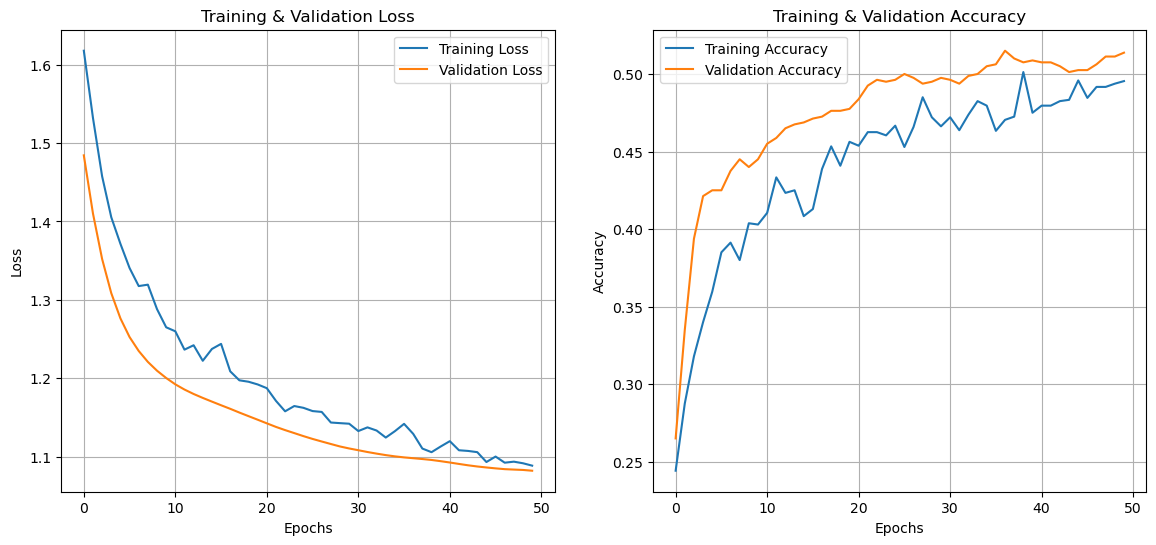

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left Plot: Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Right Plot: Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

In [7]:
# Evaluate on Validation Set
print("Evaluating on Validation Set...")
y_pred_val_prob = model.predict(X_val)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report (Validation):\n")
print(classification_report(y_val, y_pred_val))

Evaluating on Validation Set...
25/25 [==============================] - 0s 2ms/step
Validation Accuracy: 0.51375

Classification Report (Validation):

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       200
           1       0.48      0.43      0.45       200
           2       0.42      0.32      0.36       214
           3       0.49      0.67      0.57       186

    accuracy                           0.51       800
   macro avg       0.51      0.52      0.51       800
weighted avg       0.51      0.51      0.51       800



In [8]:
# Evaluate on Test Set
print("Evaluating on Test Set...")
y_pred_test_prob = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report (Test):\n")
print(classification_report(y_test, y_pred_test))

Evaluating on Test Set...
25/25 [==============================] - 0s 2ms/step
Test Accuracy: 0.48125

Classification Report (Test):

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       194
           1       0.44      0.34      0.38       209
           2       0.35      0.30      0.32       191
           3       0.50      0.65      0.56       206

    accuracy                           0.48       800
   macro avg       0.47      0.48      0.47       800
weighted avg       0.47      0.48      0.47       800

